## MANOS A LA OBRAAA!!!!

Finalmente llegamos a la instancia de ML. Las actividades a realizar son las siguientes.

1. Luego del preprocesamiento del dataset, definimos nuestro dataset "final". Con este dataset comenzaremos a entrenar nuestros modelos, comenzando por el más sencillo para establecerlo como baseline y luego yendo hacia otros más complejos.

2. Como se habrán dado cuenta, nuestro problema es un problema de aprendizaje supervisado y podemos abordarlo como un problema de clasificacion o un problema de regresión. La idea es que trabajen ambas opciones implementando inicialmente algún modelo lineal sencillo para cada caso. No se olviden de normalizar las variables si el modelo lo requiere.

3. En el problema de regresion, evaluen la performance del modelo lineal si modifican el valor de la columna target por su logaritmo (new_target --> ln(target)). Primero apliquen ln y despues normalicen.

4. Implementen modelos de mayor complejidad como Random Forest y haciendo uso de GridSearchCV busquen los hiperparametros que optimizan el modelo para los problemas de regresion y clasificacion.

5. Elijan el caso de regresion o clasificación y para este caso, implementen redes neuronales optimizando sus hiperparametros.

6. Apliquen el modelo a un nuevo dataset.

### 1. Definir el data set

Por lo visto en los entregables anteriores, se utilizara el data set con las columnas de hielo reemplazadas por un valor representativo, el porcentil 75.


In [56]:
## Cargamos las librerias que necesitaremos
import matplotlib.pyplot as plt
import pickle
import seaborn as sb
import pandas as pd
import numpy as np
from google.colab import drive
from google.colab import files

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import plot_tree
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
# Cargamos el pkl
with open('/content/drive/MyDrive/my_df.pkl', 'rb') as f:
    df = pickle.load(f)

print("Archivo cargado con éxito.")

Archivo cargado con éxito.


In [5]:
## Creo una copia para manipular, para mejorar el tiempo de computo se tomara un sample 10 veces mas chico
sample_size = 50000
df_copy = df.sample(sample_size)

# Tratamiento de las columnas de hielo para relevarlas solo con un valor representativo del conjunto
Ice_columns = df_copy.columns[10:36]
df_copy.loc[:, 'Ice_values'] = df_copy.loc[:, Ice_columns].values.tolist()
df_copy.loc[:, 'Ice_q75'] = df_copy.Ice_values.apply(np.quantile, args=(0.75,))

# Dropeo columnas que no son relevantes y reordeno las columnas
dropable_columns = list(df_copy.columns[:40]) + ['Ice_values']
df_copy = df_copy.drop(columns=dropable_columns)

# Reordeno las columnas con el target a la cabeza
ordered_columns = ['LIGHT', 'Ice_q75'] + list(df_copy.columns[:3])
df_copy = df_copy[ordered_columns]

df_copy

,LIGHT,Ice_q75,CTT,LPI,MDBZ
287470,7.0,5.941715e-03,202.327148,1.589279,48.231838
435431,0.0,1.594641e-07,220.273163,0.000000,-13.645392
262798,11.0,3.789565e-03,206.547958,44.697113,44.025589
14868,2.0,2.403541e-03,201.441727,9.677159,44.624359
278294,33.0,6.707496e-03,206.323334,15.719129,45.423260
...,...,...,...,...,...
12196,38.0,6.208219e-03,209.965988,0.715631,49.657696
441676,1.0,3.660560e-03,197.481308,9.194933,48.136059
262719,0.0,7.369402e-10,293.977875,0.000000,-30.000000
22962,47.0,8.051916e-03,199.145294,222.960373,57.120541


In [6]:
df_regresion = df_copy.copy()

# Normalizo el data set
columns = df_regresion.columns
df_regresion = StandardScaler().fit_transform(df_regresion)
df_regresion = pd.DataFrame(df_regresion, columns=columns)

df_regresion

,LIGHT,Ice_q75,CTT,LPI,MDBZ
0,-0.099735,1.467710,-0.438894,-0.434875,0.776872
1,-0.384109,-1.003164,0.201759,-0.460803,-1.685788
2,0.062765,0.572710,-0.288216,0.268407,0.609467
3,-0.302860,-0.003687,-0.470503,-0.302925,0.633297
4,0.956513,1.786170,-0.296235,-0.204353,0.665093
...,...,...,...,...,...
49995,1.159638,1.578539,-0.166196,-0.449128,0.833619
49996,-0.343485,0.519061,-0.611885,-0.310792,0.773060
49997,-0.384109,-1.003230,2.832937,-0.460803,-2.336687
49998,1.525262,2.345264,-0.552483,3.176679,1.130634


El resultado es un data set con la columna target `LIGHT` y nos quedamos solo con una columna con informacion relevante sobre el hielo.

Para el caso de clasificacion, se consideraran como actividad electrica nula a aquellos valores de `LIGHT` menores a 5, esta se denotara con `0` y la actividad nula se clasificara con `1`.

In [7]:
# Defino una funcion para crear etiquetas para aplicarla al data set
def actividad_electrica(light):
  if light != 0: return 1
  else: return 0

df_clasificacion = df_copy.copy()
df_clasificacion.loc[:, 'LIGHT'] = df_clasificacion.LIGHT.apply(actividad_electrica)

# Normalizo el data set para ser consistente con lo analizado en regresion
columns = df_clasificacion.columns
light_clas = df_clasificacion.LIGHT
df_clasificacion = StandardScaler().fit_transform(df_clasificacion)
df_clasificacion = pd.DataFrame(df_clasificacion, columns=columns)

df_clasificacion.LIGHT = list(light_clas)
df_clasificacion

<ipython-input-7-13b97f6b4c1a>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_clasificacion.loc[:, 'LIGHT'] = df_clasificacion.LIGHT.apply(actividad_electrica)


,LIGHT,Ice_q75,CTT,LPI,MDBZ
0,1,1.467710,-0.438894,-0.434875,0.776872
1,0,-1.003164,0.201759,-0.460803,-1.685788
2,1,0.572710,-0.288216,0.268407,0.609467
3,1,-0.003687,-0.470503,-0.302925,0.633297
4,1,1.786170,-0.296235,-0.204353,0.665093
...,...,...,...,...,...
49995,1,1.578539,-0.166196,-0.449128,0.833619
49996,1,0.519061,-0.611885,-0.310792,0.773060
49997,0,-1.003230,2.832937,-0.460803,-2.336687
49998,1,2.345264,-0.552483,3.176679,1.130634


### 2. Definicion de modelos baseline

Como baseline para el caso de regresion se opto por usa el `Ridge` y para el caso de clasificacion un `DecisionTreeClassifier`.

In [8]:
# Definimos una funcion para partir el data set en: train, test y validate
def spliting_data(df):
  train, test = train_test_split(df, test_size=0.2, random_state=0)

  x_train, x_test  = train.iloc[:,1:], test.iloc[:,1:]
  y_train, y_test = train.iloc[:,0], test.iloc[:,0]

  # test, validate = train_test_split(df, test_size=0.2, random_state=0)
  # x_validate = validate.iloc[:,1:]
  # y_validate = validate.iloc[:,0]
  return x_train, x_test, y_train, y_test

x_train_r, x_test_r, y_train_r, y_test_r = spliting_data(df_regresion)
x_train_c, x_test_c, y_train_c, y_test_c = spliting_data(df_clasificacion)

In [9]:
# Definimos una funcion para facilitar el ajuste de parametros
def entrenar_hiperparametros(model, grid, x, y, scoring):

  grid_result = GridSearchCV(model,
                              grid,
                              n_jobs=-1,
                              scoring=scoring).fit(x, y)
  print(model.__class__.__name__)
  print('Best params:',grid_result.best_params_)

  return grid_result.best_params_



# Lo mismo para facilitar la visualizacion de metricas
def resultados_modelo_clasificacion(model, x, y, x_test, y_test):

    name = model.__class__.__name__
    print(name)
    train_predictions = model.predict(x)
    accuracy = accuracy_score(y, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    print('\n\n')


def resultados_modelo_regresion(model, x, y, x_test, y_test):

    name = model.__class__.__name__
    print(name)
    train_predictions = model.predict(x)
    r2 = r2_score(y, train_predictions)
    print(f"R2 score train {name}: ", r2)

    test_predictions = model.predict(x_test)
    r2 = r2_score(y_test, test_predictions)
    print(f"R2 score test {name}: ", r2)
    print('\n\n')

# Una funcion de ayuda para repetir el entrenamiento y resultados para diferentes modelos
def entrenar(model, grid, x, y, x_test, y_test, scoring='accuracy'):

  best_params = entrenar_hiperparametros(model(), grid, x, y, scoring)
  model_entrenado = model(**best_params).fit(x,y)

  return model_entrenado

In [10]:
# Modelos Baseline

# grid = {
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'splitter': ['best', 'random'],
#     'max_depth': [10,15,20],
#     'min_samples_split': [5,10,50,100],
#     'max_features': ['sqrt', 'log2', 'auto'],
#     'random_state': [0]
# }
# tree = entrenar(DecisionTreeClassifier, grid, x_train_c, y_train_c, x_test_c, y_test_c, scoring='accuracy')
best_params = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 50, 'random_state': 0, 'splitter': 'best'}
tree = DecisionTreeClassifier(**best_params).fit(x_train_c, y_train_c)

resultados_modelo_clasificacion(tree, x_train_c, y_train_c, x_test_c, y_test_c)


# grid = {
#     'alpha': [1e-7, 1e-8, 1e-9, 1e-10],
#     'fit_intercept': [True, False],
#     'positive': [True, False],
#     'random_state': [0]
# }
# rid = entrenar(Ridge, grid, x_train_r, y_train_r, x_test_r, y_test_r, scoring='r2')
best_params = {'alpha': 1e-09, 'fit_intercept': False, 'positive': False, 'random_state': 0}
rid = Ridge(**best_params).fit(x_train_r, y_train_r)

resultados_modelo_regresion(rid, x_train_r, y_train_r, x_test_r, y_test_r)

DecisionTreeClassifier
Accuracy train DecisionTreeClassifier: 97.70%
Accuracy test DecisionTreeClassifier: 97.29%



Ridge
R2 score train Ridge:  0.162229475908928
R2 score test Ridge:  0.16232845253272588





Resultados del arbol de decision:

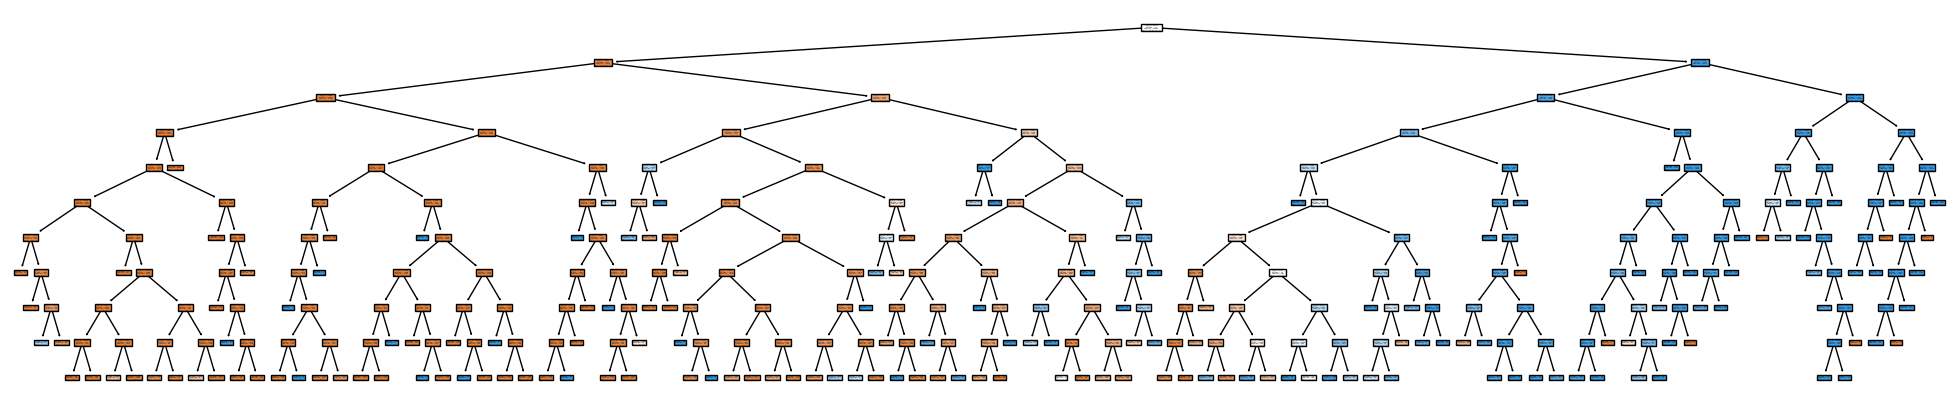

In [11]:
plt.figure(figsize=(25,5))
plot_tree(tree, filled=True)
plt.show()

Resultados del modelo Ridge

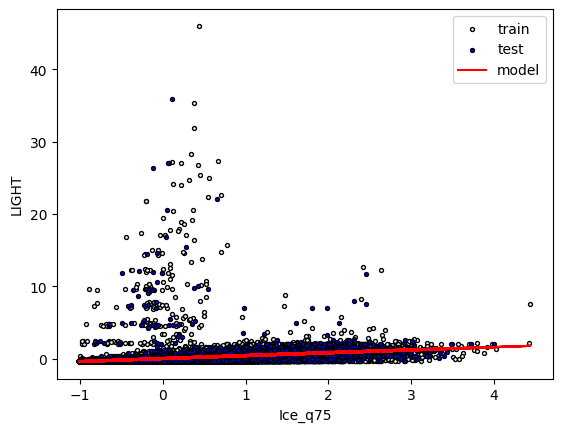

In [17]:
plt.scatter(x_train_r['Ice_q75'], y_train_r, color='white', edgecolor='k', label='train',s=8)
plt.scatter(x_test_r['Ice_q75'], y_test_r, color='blue', edgecolor='k', label='test',s=8)
plt.plot(x_train_r['Ice_q75'], rid.predict(x_train_r), color='red', label='model')
plt.legend()
plt.xlabel('Ice_q75')
plt.ylabel('LIGHT')
plt.show()

### 3. Aplicacion de Log a la columna target

Para realizar una mejor comparativa entre el desempeño, se utilizaran los mismos parametros con los que se entreno el modelo original.

Para el caso de valores nulos, se reemplaza la transformacion por -1 para evitar infinitos. A fines practicos es identico a sumar 0.1 a todas los valores de LIGHT.

In [18]:
df_log = df_copy.copy()
df_log.LIGHT.apply(np.log)
df_log.LIGHT.replace([np.inf, -np.inf], -1, inplace=True)

columns = df_log.columns
df_log = StandardScaler().fit_transform(df_log)
df_log = pd.DataFrame(df_log, columns=columns)

df_log

,LIGHT,Ice_q75,CTT,LPI,MDBZ
0,-0.099735,1.467710,-0.438894,-0.434875,0.776872
1,-0.384109,-1.003164,0.201759,-0.460803,-1.685788
2,0.062765,0.572710,-0.288216,0.268407,0.609467
3,-0.302860,-0.003687,-0.470503,-0.302925,0.633297
4,0.956513,1.786170,-0.296235,-0.204353,0.665093
...,...,...,...,...,...
49995,1.159638,1.578539,-0.166196,-0.449128,0.833619
49996,-0.343485,0.519061,-0.611885,-0.310792,0.773060
49997,-0.384109,-1.003230,2.832937,-0.460803,-2.336687
49998,1.525262,2.345264,-0.552483,3.176679,1.130634


In [19]:
x_train_log, x_test_log, y_train_log, y_test_log = spliting_data(df_log)

# Entreno con los mismo hiperparametros encontrados anteriormente
regresion_best_params = {'alpha': 0.5, 'fit_intercept': True, 'positive': True}

rid_log = Ridge(**regresion_best_params).fit(x_train_log, y_train_log)
resultados_modelo_regresion(rid_log, x_train_log, y_train_log, x_test_log, y_test_log)

Ridge
R2 score train Ridge:  0.162232234700726
R2 score test Ridge:  0.16230408111545036





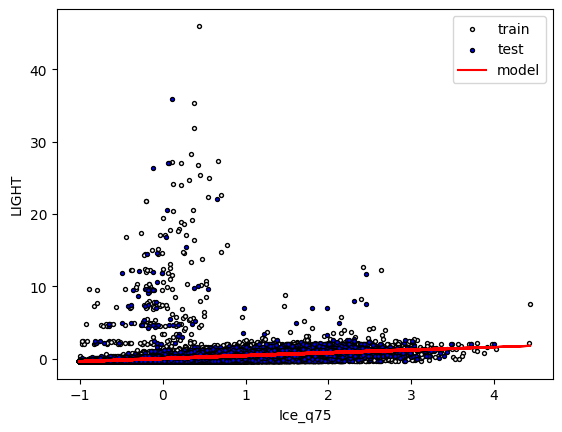

In [20]:
plt.scatter(x_train_log['Ice_q75'], y_train_log, color='white', edgecolor='k', label='train',s=8)
plt.scatter(x_test_log['Ice_q75'], y_test_log, color='blue', edgecolor='k', label='test',s=8)
plt.plot(x_train_log['Ice_q75'], rid_log.predict(x_train_log), color='red', label='model')
plt.legend()
plt.xlabel('Ice_q75')
plt.ylabel('LIGHT')
plt.show()

El desempeño en las metricas del modelo mejoro enormemente, pasando a tener un error cuadratico medio de 0.85

### 4. Entrenamiento de modelos complejos

Para ambos casos (regresion y clasificacion), se tomara 1 modelo avanzado para cada tipo de problema. Se selecciono `RandomForestClassifier` para el caso de clasificacion y `SGDRegressor` para el caso de regresion.

Para hacer mas simple el entrenamiento de hiperparametros, se utilizaran las funciones de ayuda que se definieron en los incisos anteriores. Aprovacharemos ademas el hecho de que ya contamos con las particiones de entrenamiento y testeo para entrenar los modelos.

In [23]:
# Modelos avanzados

# grid = {
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'n_estimators': [20, 50, 100, 150],
#     'max_depth': [10,15,20],
#     'min_samples_split': [5,10,50,100],
#     'max_features': ['sqrt', 'log2'],
#     'random_state': [0]
# }
# rand_tree = entrenar(RandomForestClassifier, grid, x_train_c, y_train_c, x_test_c, y_test_c, scoring='accuracy')
best_params = {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 0}
rand_tree = RandomForestClassifier(**best_params).fit(x_train_c, y_train_c)

resultados_modelo_clasificacion(rand_tree, x_train_c, y_train_c, x_test_c, y_test_c)


# grid = {
#     'penalty': ['l2', 'l1'],
#     'alpha': [1e-4, 1e-5, 1e-6],
#     'fit_intercept': [True, False],
#     'learning_rate': ['constant', 'optimal', 'invscaling'],
#     'random_state': [0]
# }
# sgd = entrenar(SGDRegressor, grid, x_train_r, y_train_r, x_test_r, y_test_r, scoring='r2')
best_params = {'alpha': 1e-05, 'fit_intercept': False, 'learning_rate': 'invscaling', 'penalty': 'l1', 'random_state': 0}
sgd = SGDRegressor(**best_params).fit(x_train_r, y_train_r)

resultados_modelo_regresion(sgd, x_train_r, y_train_r, x_test_r, y_test_r)

RandomForestClassifier
Accuracy train RandomForestClassifier: 99.59%
Accuracy test RandomForestClassifier: 97.87%



SGDRegressor
R2 score train SGDRegressor:  0.162194031678358
R2 score test SGDRegressor:  0.16230298913032604





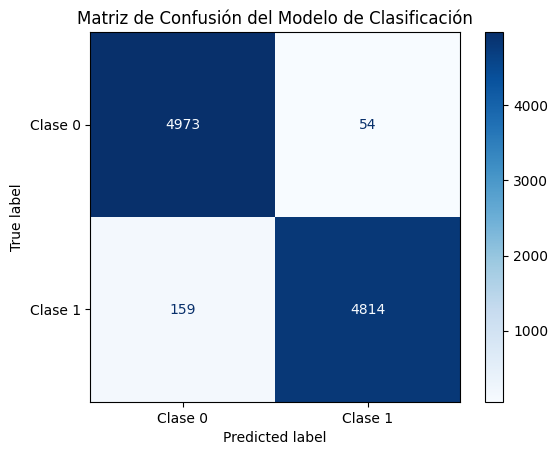

In [52]:
# Predicciones del modelo RandomForestClassifier
y_pred_rf = rand_tree.predict(x_test_c)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_c, y_pred_rf)

ConfusionMatrixDisplay(conf_matrix, display_labels=['Clase 0', 'Clase 1']).plot(cmap='Blues')
plt.title('Matriz de Confusión del Modelo RandomForestClassifier')
plt.show()

Alto número de verdaderos positivos y verdaderos negativos con mínimos falsos positivos y falsos negativos, lo que indica un buen rendimiento del modelo de clasificación.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


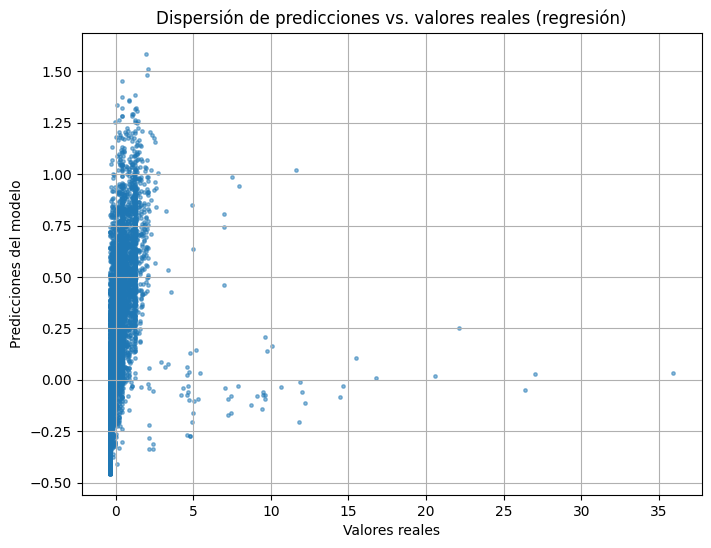

In [55]:
# Predicciones del modelo SGDRegressor
y_pred_sgd = sgd.predict(x_test_r)

# Dispersión para regresión
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred_sgd, alpha=0.5,s=6)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones del modelo')
plt.title('Dispersión de predicciones vs. valores reales (regresión)')
plt.grid(True)
plt.show()

Se podria optimizar mas la busqueda de hiperparametros, pero a falta de poder de computo se eligio una validacion cruzada mas contenida para poder encontrar resultados en un tiempo razonable.

Si bien no se aprecia demasiada ganancia en el modelo de clasificacion, para el caso de regresion encontramos una mejora muy significativa del desempeño, superando ampliamente al modelo de regresion baseline.

### 5. Redes neuronales


In [ ]:
# Entrenamiento y test usando el modelo de regresión
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(df_regresion.iloc[:, 1:], df_regresion.iloc[:, 0], test_size=0.2, random_state=0)

# Normalizar
scaler = StandardScaler()
x_train_r = scaler.fit_transform(x_train_r)
x_test_r = scaler.transform(x_test_r)

In [ ]:
# Función para crear el modelo de red neuronal
def create_model(neurons=64, activation='relu'):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(x_train_r.shape[1],)),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dense(1)  # Capa de salida para la regresión
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
# Hiperparámetros para buscar con GridSearchCV (se buscará la mejor combinación)
param_grid = {
    'neurons': [32, 64, 128],
    'activation': ['relu', 'tanh']
}

best_mse = float('inf')
best_model = None

In [ ]:
# Realizar la búsqueda de hiperparámetros (combina 3 cantidades de neuronas en la capa oculta de la red )
#                                           y 2 funciones de activación diferentes 'relu' y 'tanh')
for neurons in param_grid['neurons']:
    for activation in param_grid['activation']:
        model = create_model(neurons=neurons, activation=activation)
        model.fit(x_train_r, y_train_r, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(x_test_r)
        mse = mean_squared_error(y_test_r, y_pred)
        print(f"Neurons={neurons}, Activation={activation}, Error Cuadrático Medio (MSE)={mse}")
        if mse < best_mse:
            best_mse = mse
            best_model = model

In [ ]:
# Mejor modelo en el conjunto de prueba
mse_final = best_model.evaluate(x_test_r, y_test_r)
print("Error Cuadrático Medio del mejor modelo:", mse_final)

In [48]:
y_pred = best_model.predict(x_test_r) # Predicciones del mejor modelo

# R-squared
r2 = r2_score(y_test_r, y_pred)
print("R-squared:", r2)

313/313 [==============================] - 1s 2ms/step
R-squared: 0.18827964408302023


Se observa entonces que el mejor modelo (con MSE más bajo) es con 64 neuronas y con la función 'relu' (Rectified Linear Unit).

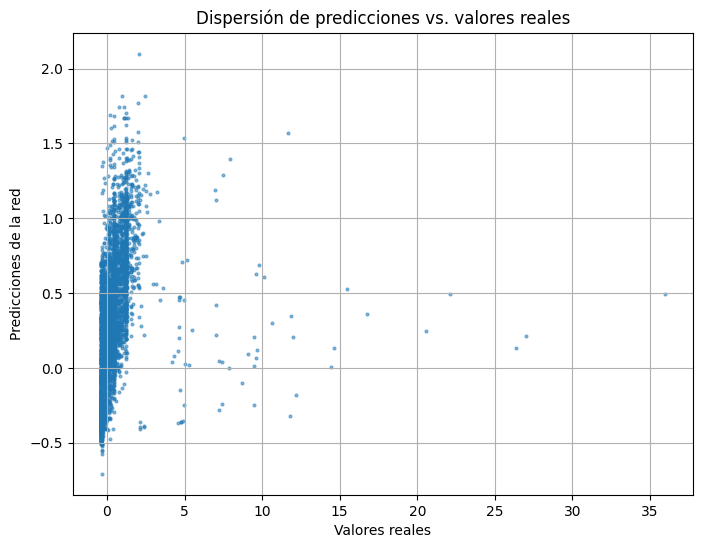

In [49]:
# Crea un gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(y_test_r, y_pred, alpha=0.5,s=4)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones de la red')
plt.title('Dispersión de predicciones vs. valores reales')
plt.grid(True)
plt.show()

Se observa que la maypría de los datos tienen un comportamiento lineal. Sólo para un conjunto reducido de datos de valor alto (etiquetas de 'LIGHT'), la red no predice correctamente.

### 6. Testeo en un dataset nuevo

In [64]:
uploaded = files.upload()
df = pd.read_csv('mentoria_test.csv')
df.head()

Saving mentoria_test.csv to mentoria_test (2).csv


,Unnamed: 0,MAXICE,INTICE,MAXW,LPI,GRADIENT_ICE,CTT,MEANICE,ICE_75,MDBZ,lats,lons,time,LIGHT
0,0,0.000325,0.001807,0.810697,0.095614,0.000057,-71.936798,0.000045,2.126976e-05,32.346443,-33.598438,-60.129272,0.0,0.0
1,1,0.000281,0.002089,1.161332,0.007620,-0.000091,-70.511009,0.000052,6.561460e-05,33.718971,-33.595718,-59.999817,0.0,0.0
2,2,0.000319,0.001474,0.106723,0.010839,0.000094,-70.199265,0.000037,4.461235e-06,32.596329,-33.591900,-59.827240,0.0,0.0
3,3,0.000256,0.001214,0.033029,0.018655,0.000108,-70.850616,0.000030,2.839991e-06,32.543098,-33.590908,-59.784088,0.0,0.0
4,4,0.000102,0.000168,5.122447,0.212262,-0.000070,-7.742917,0.000004,1.782562e-09,41.847157,-33.595234,-60.971252,0.0,0.0


In [65]:
# Dejamos las columnas relevantes
col_relevantes = ['LIGHT', 'ICE_75', 'CTT', 'LPI', 'MDBZ', 'lats', 'lons', 'time']
df_test = df[col_relevantes]

df = df_test
df_test.head()

,LIGHT,ICE_75,CTT,LPI,MDBZ,lats,lons,time
0,0.0,2.126976e-05,-71.936798,0.095614,32.346443,-33.598438,-60.129272,0.0
1,0.0,6.561460e-05,-70.511009,0.007620,33.718971,-33.595718,-59.999817,0.0
2,0.0,4.461235e-06,-70.199265,0.010839,32.596329,-33.591900,-59.827240,0.0
3,0.0,2.839991e-06,-70.850616,0.018655,32.543098,-33.590908,-59.784088,0.0
4,0.0,1.782562e-09,-7.742917,0.212262,41.847157,-33.595234,-60.971252,0.0


In [72]:
# Número de grupos de valores únicos en la columna 'time'
num_unique_groups = df_test['time'].nunique()
print(f"Número de grupos únicos en la columna 'time': {num_unique_groups}")

# Cantidad de valores repetidos en 'time'
time_counts = df_test['time'].value_counts()
print("Conteo de valores repetidos en 'time':")
print(time_counts)

Número de grupos únicos en la columna 'time': 566
Conteo de valores repetidos en 'time':
35.000000    12
14.000000    11
31.000000    11
30.000000    11
10.000000    10
             ..
34.526316     1
36.280000     1
35.772727     1
33.120000     1
32.500000     1
Name: time, Length: 566, dtype: int64
